***STATE DEFINITIONS***

In [98]:
from langgraph.graph import MessagesState
from typing_extensions import Optional, Annotated, List, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# input scheme
class ScopeAgentInputState(MessagesState) :
    """Input state for the full agent - only contains messages from user input."""
    pass

class ScopeAgentState(MessagesState) :
    """
    Main state for the full multi-agent research system.

    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """
      # Research brief generated from user conversation history
    research_brief: Optional[str]
    # Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed and structured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    # Final formatted research report
    final_report: str



***STRUCTURED OUTPUT SCHEMAS***

In [99]:
from pydantic import BaseModel, Field

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )
class ResearchQuestion(BaseModel):
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )




***model***

In [100]:
from langchain.chat_models import init_chat_model
import os
from dotenv import load_dotenv
load_dotenv()
model = init_chat_model(model="openai:qwen-plus",api_key=os.getenv("OPENAI_API_KEY"),base_url=os.getenv("OPENAI_API_URL"),temperature=0.0,)

***Prompts***

In [101]:
from deep_research_from_scratch.prompts import BRIEF_CRITERIA_PROMPT
from deep_research_from_scratch.prompts import clarify_with_user_instructions,transform_messages_into_research_topic_prompt
from utils import show_prompt
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

***Scope Research and wirte brief***

In [102]:
from typing_extensions import Literal
from langgraph.types import Command
from langchain_core.messages import HumanMessage,AIMessage,get_buffer_string
from langgraph.graph import END
from datetime import datetime
# UTILITY FUNCTIONS
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %d, %Y")
def clarify_with_user(state:ScopeAgentState)-> Command[Literal["write_research_brief","__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed with research.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    # 结构化输出
    structured_output_model=model.with_structured_output(ClarifyWithUser,method="function_calling")
    response=structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]),
            date=get_today_str()
        ))       
    ])
    if response.need_clarification:
        goto=END
        update={"messages":[AIMessage(content=response.question)]}
    else:
        goto="write_research_brief",
        update={"messages":[AIMessage(content=response.verification)]}

    return Command(goto=goto,update=update)


def write_research_brief(state: ScopeAgentState):
    """
    Transform the conversation history into a comprehensive research brief.
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    structured_output_model=model.with_structured_output(ResearchQuestion,method="function_calling")
    response=structured_output_model.invoke([HumanMessage(content=transform_messages_into_research_topic_prompt.format(
        messages=get_buffer_string(state.get("messages",[])),
        date=get_today_str()
    ))])
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }


***Scope Research and wirte brief***

***Scope Research and wirte brief***

***Scope Research and wirte brief***

***Scope Research and wirte brief***

***graph compose***

In [103]:
from langgraph.graph import StateGraph
from langgraph.graph import START,END
deep_researcher_builder=StateGraph(ScopeAgentState,input_schema=ScopeAgentInputState)
# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)
# Compile the workflow
scope_research = deep_researcher_builder.compile()

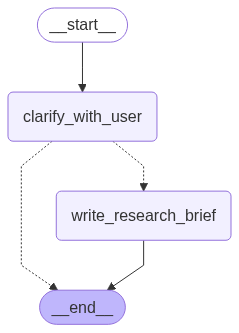

In [104]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

***Scope Research and wirte brief***

In [105]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify if you are looking for coffee shops in specific neighborhoods within San Francisco or if      │
│ there are any particular criteria (e.g., ambiance, menu options, availability of seating, or proximity to       │
│ attractions) that should be considered?                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [106]:
result = scope.invoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify if you are looking for coffee shops in specific neighborhoods within San Francisco or if      │
│ there are any particular criteria (e.g., ambiance, menu options, availability of seating, or proximity to       │
│ attractions) that should be considered?                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Acknowledged. You are looking to assess the best coffee shops in San Francisco based on coffee quality. I will  │
│ now begin the research process.                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

***Scope Research and wirte brief***